In [ ]:
import numpy as np
import tensorflow as tf
import math
from scipy.special import expit
from scipy.stats import norm
import sklearn.metrics

import matplotlib.pyplot as plt

## Loading data

In [2]:
data = np.load("data.npy")
data.shape

(100000, 12320)

## Shuffling and split on train and test

In [3]:
np.random.shuffle(data)
thres = round(len(data) * 0.7)

train = data[:thres]
test = data[thres:]

print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (70000, 12320)
Test: (30000, 12320)


## Separating features from labels

In [4]:
landmark_genes = 970
lset = list(range(landmark_genes))
nlset = list(range(landmark_genes, data.shape[1]))
print("Number of landmark genes: " + str(len(lset)))
print("Number of non-landmark genes: " + str(len(nlset)))

Number of landmark genes: 970
Number of non-landmark genes: 11350


In [5]:
train = (train[:, lset], train[:, nlset])
test = (test[:, lset], test[:, nlset])
data = None
print("Features shape: " + str(train[0].shape))
print("Output shape" + str(train[1].shape))

Features shape: (70000, 970)
Output shape(70000, 11350)


### Multilayer perceptron

Some features of the implementation:
* Adam's variation of stochastic gradient descent
* Using minibatches to speed up convergence and avoid performance issues
* Output layer without activation
* Stops if validation score isn't improving 
* L2 regularization

In [40]:
def split(X, k):
    return np.split(range(len(X)), [i * k for i in range(1, len(X) // k)])

In [62]:
class MLP:
    eps = 1e-8
    
    def __init__(self, batchsize = 200, beta1 = 0.9, beta2 = 0.999, alpha = 0.0001, 
                 eta = 0.001,  structure = (), tol = 0.001):
        self.batchsize = batchsize
        self.beta1 = beta1
        self.beta2 = beta2
        self.alpha = alpha
        self.structure = structure
        self.tol = tol
        self.eta = eta
        
    def permute(self):
        permutation = np.random.permutation(len(self.X))
        self.X = self.X[permutation]
        self.Y = self.Y[permutation]
        
    def step(self):
        f = lambda A: A * (1 - A)
        self.permute()
        k = self.batchsize
        batches = split(self.X, k)
        J = []
        for b in batches:
            A = self.predict_(self.X[b])
            Y = self.Y[b]
            X = self.X[b]
            delta = [None] * len(self.W)
            E = Y - A[-1]
            delta[-1] = E
            self.J.append((E ** 2).sum() / len(X))
            # Computing local gradinents
            for i in range(len(self.W) - 2, -1, -1):
                if i == len(self.W) - 2:
                    delta[i] = np.dot(delta[i + 1], self.W[i + 1].T) * f(A[i + 1])
                else:
                    delta[i] = np.dot(delta[i + 1][:, 1:], self.W[i + 1].T) * f(A[i + 1]) 
                
            for i in range(len(self.W) - 1, -1, -1):
                if i == len(self.W) - 1:
                    grad = (np.dot(A[i].T, delta[i]) + self.alpha * self.W[i]) 
                else:
                    grad = (np.dot(A[i].T, delta[i][:, 1:]) + self.alpha * self.W[i])
                # Adam sgd
                self.M[i] = self.beta1 * self.M[i] + (1 - self.beta1) * grad
                self.V[i] = self.beta2 * self.V[i] + (1 - self.beta2) * (grad ** 2)
                m = self.M[i] / (1 - self.beta1)
                v = self.V[i] / (1 - self.beta2)
                self.W[i] += (self.eta * m) / (np.sqrt(v) + self.eps)  
            
    def fit(self, X, Y, VX, VY):
        self.J = [float('inf')]
        self.X = X
        self.Y = Y
        s = (X.shape[1], *self.structure, Y.shape[1])
        self.W, self.M, self.V = [], [], []
        for i in range(len(s) - 1):
            n = (s[i] + 1) * s[i + 1]
            shape = (s[i] + 1, s[i + 1])
            self.W.append(norm(0, 0.01).rvs(n).reshape(*shape))
            self.M.append(np.zeros(n).reshape(*shape))            
            self.V.append(np.zeros(n).reshape(*shape))
        
        VL = []
        while True:
            VL.append(((self.predict(VX) - VY) ** 2).sum() / len(VX))
            if len(VL) > 2 and max(VL[-3] - VL[-1], VL[-3] - VL[-2]) < self.tol:
                return
            self.step()
            
    def steps(self, n):
        for i in range(n):
            self.step()
        
    def predict_(self, X):
        f = expit
        T = X
        T = np.hstack((np.ones(len(T)).reshape(-1,1), T))
        A = [T]
        for i in range(len(self.W)):
            layer = self.W[i]
            T = np.dot(T, layer)
            if i != len(self.W) - 1:
                T = f(T)
                T = np.hstack((np.ones(len(T)).reshape(-1,1), T))
            A.append(T)
        return A
    
    def predict(self, X):
        return self.predict_(X)[-1]

In [57]:
X, Y, VX, VY = train[0], train[1][:, 0:1], test[0], test[1][:, 0:1]

In [25]:
mlp = MLP(structure = (500, 500))
mlp.fit(X, Y, VX, VY)

Test: 1.01419168314
Test: 0.235727529272
Test: 0.223475766805
Test: 0.219329132728
Test: 0.211287875136
Test: 0.207911198907
Test: 0.207650678073
Test: 0.20116991265
Test: 0.199839527678
Test: 0.199130711847
Test: 0.197749861764
Test: 0.197894112962
Test: 0.19736063411


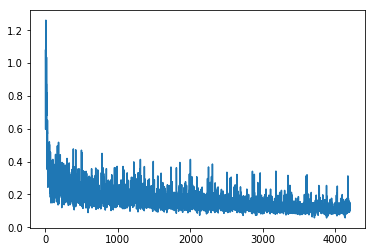

0.11517164752666492

In [31]:
plt.plot(mlp.J)
plt.show()
mlp.J[-1]

### Ensemble method

In [94]:
class KFMLP:
    def __init__(self, k, num):
        self.k = k
        self.num = num

    def fit(self, rawX, rawY, args):
        self.regs = []
        for i in range(self.num): 
            permutation = np.random.permutation(len(rawX))
            X = rawX[permutation]
            Y = rawY[permutation]
            batches = split(X, self.k)
            n = len(batches)
            for b in batches:
                train = [*range(b[0]), *range(b[-1] + 1, len(X))]
                valid = b
                self.regs.append(MLP(**args))
                self.regs[-1].fit(X[train], Y[train], X[valid], Y[valid])
    
    def predict(self, X):
        return np.mean([reg.predict(X) for reg in self.regs], axis = 0)

In [96]:
regressor = KFMLP(10000, 3)
regressor.fit(X, Y, {'structure' : (500, 500)})

1.04807956086	inf
0.233615955011	0.280396293088
0.219746175153	0.126150625207
0.220150929035	0.235186504731
0.207847664631	0.169616033487
0.208020428619	0.29535163147
0.202908078502	0.0955773916724
0.20119900941	0.111528677052
0.205765799738	0.127056322417
0.196159390186	0.114739085646
0.193549003452	0.232837316832
0.194956047628	0.121558138457
0.194132716838	0.132744156141
1.06084490277	inf
0.239774627695	0.227004538633
0.214691790284	0.143517261912
0.211930973467	0.194532691652
0.208351349977	0.172643126503
0.203564804708	0.114578977269
0.200743656562	0.149474961526
0.19999124542	0.127378241949
0.201922724472	0.137223719317
0.997524106975	inf
0.236376897343	0.248211352191
0.216674844711	0.150020240741
0.207823398031	0.150805488555
0.2101415996	0.188258176529
0.2022542267	0.13069198786
0.198893695057	0.139583018012
0.203058771557	0.193093427779
0.194813567027	0.169684946897
0.195830207371	0.124232877669
0.195786045925	0.143456472289
1.07439481695	inf
0.23264745273	0.583413141719
0.216

In [97]:
print('Train: ' + str(sklearn.metrics.mean_squared_error(Y, regressor.predict(X))))
print('Test: ' + str(sklearn.metrics.mean_squared_error(VY, regressor.predict(VX))))

Train: 0.118668045625
Test: 0.193307963702


### Regularization

In [102]:
mlpalpha = MLP(structure = (500, 500), alpha=0.01)
mlpalpha.fit(X, Y, VX, VY)

1.0167907488	inf
0.233259973958	0.28746199441
0.220987870574	0.235200378656
0.213564791736	0.173674678656
0.208772663125	0.187728518141
0.207283022079	0.157447126852
0.203620508604	0.187095091847
0.202778775213	0.161387512452
0.197853540434	0.110519335566
0.198713327888	0.111960944274
0.19669026123	0.116108093195
0.19728110117	0.134214324606
0.19638305755	0.106025749657


In [99]:
print('Train: ' + str(sklearn.metrics.mean_squared_error(Y, mlpalpha.predict(X))))
print('Test: ' + str(sklearn.metrics.mean_squared_error(VY, mlpalpha.predict(VX))))

Train: 0.115652637595
Test: 0.204945631984


### Fewer neurons

In [101]:
mlpalpha = MLP(structure = (50, 50), alpha=0.001)
mlpalpha.fit(X, Y, VX, VY)

1.00889639937	inf
0.294530237824	0.308309779585
0.250615236168	0.290763705334
0.23341996388	0.251218636902
0.224857479547	0.196613418594
0.220125805289	0.179614811503
0.219310453197	0.12335551128
0.219848721686	0.173440925778


In [ ]:
mlp = MLP(structure=(100, 100), batchsize=500)
mlp.fit(train[0], train[1], test[0], test[1])

11400.5096572	inf
9548.042945	10021.5727796
8187.93673569	7530.43734824
7482.89367286	7575.99404684
6967.49662732	7121.79861741
6598.77708842	7084.76749567
6268.72555776	6473.19050667
6060.96506795	5836.85952535
5919.78022122	5934.62141254
5801.87151702	6098.69569606
5699.37630056	6167.83054272
5611.36400686	5483.42608092
5538.13696146	5356.63659912
5473.16061811	5406.52108002
5415.08717815	5042.09114099
5362.69793157	5557.36768055
5314.87825834	5958.20948473
5271.99935221	5015.35915232
5232.73167878	5564.88482939
5196.00892168	5002.96227639
5160.96224228	5104.28397458
5128.46115231	5035.71188089
5097.61808694	5101.01258392
5068.08202712	5120.30651726
5040.10524442	4772.53153321
5014.46083156	4844.48786657
4989.21221523	4671.6349412
4965.49295965	5000.1825933
4942.81689719	4731.86383871
4921.55238769	4841.67709665
4901.38930522	4497.74617379
4882.395308	4546.97380254
4864.26768865	4734.05934125
4846.59105318	4873.71039413
4830.00115238	4829.24596278
4813.94993014	4823.69215533
4799.139

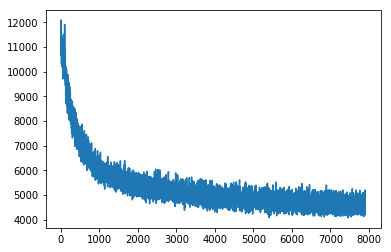

4720.5524544996906

In [106]:
plt.plot(mlp.J)
plt.show()